In [1]:
import gym
import random
import numpy as np
from statistics import median, mean
from collections import Counter
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras import backend as K
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import deque

Using TensorFlow backend.


In [2]:
LR = 1e-3
env = gym.make("CartPole-v1")

CartPoleEnv - Version 0.2.0, Noise case: 1


/home/mohanish3/anaconda3/envs/mlproject/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/mohanish3/anaconda3/envs/mlproject/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'gym.envs.classic_control.cartpole.CartPoleEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
#Plot score over episodes
def plot_res(values, title=''):   
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(100, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(500, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [4]:
def neural_network_model(input_size, output_size):

    model = Sequential()
    
    model.add(Dense(24, input_dim=input_size,activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(output_size,activation='linear'))
    
    model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    
    return model

In [5]:
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

print(input_size)
print(output_size)

model = neural_network_model(input_size, output_size)
target_model = neural_network_model(input_size, output_size)

model.summary()

4
2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


In [6]:
def replay(model, training_data, train_size):
    global epsilon, epsilon_min, epsilon_decay
    
    batch_data = random.sample(training_data, train_size)
    for t in batch_data:
        state, reward, done, new_state, action = t
        
        yi = model.predict(state)
        
        if(done):
            yi[0][action] = reward
        else:
            a = model.predict(new_state)[0]
            t = target_model.predict(new_state)[0]
            yi[0][action] = reward + gamma * t[np.argmax(a)]
        model.fit(state, yi, epochs=1, verbose=0)
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    return model

In [7]:
def next_action(state, output_size):
    if(np.random.rand() <= epsilon): #Explore: Random action
        return random.randrange(output_size)
    return np.argmax(model.predict(state)) #Exploitation: Action with best possible reward

In [8]:
scores = []
game_memory = deque(maxlen=100000)

N = 100
last_N_scores = deque(maxlen=N)
SCORE_REQUIRED = 490

goal_steps = 500
TRAIN_EPISODES = 100000

train_size = 32
update_every = 1

epsilon = 1.0 #Defines the exploration range
epsilon_min = 0.01
epsilon_decay = 0.99
gamma = 0.99

for game in range(TRAIN_EPISODES):
    state = env.reset()
    
    if game % update_every == 0:
        target_model.set_weights(model.get_weights())
    
    score = 0
    for _ in range(goal_steps):
        #env.render()
        state = state.reshape(-1, len(state))
        
        action = next_action(state, output_size)
                
        new_state, reward, done, info = env.step(action)
        
        score += reward
        if done:
            reward = -reward
        else:
            reward = reward
        
        game_memory.append((state, reward, done, new_state.reshape(-1, len(new_state)), action))
        
        state = new_state
        if done: 
            #print("episode: {}/{}, score: {}, e: {:.2}".format(game, EPISODES, _, epsilon))
            break
            
    #complete training if last N episodes yield more than required score
    last_N_scores.append(score)
    if(sum(last_N_scores)/N >= SCORE_REQUIRED):
        print('Score {} achieved at {} game'.format(SCORE_REQUIRED, game))
        break
            
    if(len(game_memory) > train_size):
        replay(model, game_memory, train_size)
    
    if(game % 100 == 0):
        print('Game {} score : {}'.format(game, score))
        scores.append(score)
        
    
if(len(scores) > 0):
    print('Average Score taken every 100 steps:',sum(scores)/len(scores))
else:
    print('Average Score:', SCORE_REQUIRED)

Game 0 score : 8.0
Game 100 score : 40.0
Game 200 score : 37.0
Game 300 score : 130.0
Game 400 score : 91.0
Game 500 score : 9.0
Game 600 score : 10.0
Game 700 score : 8.0
Game 800 score : 11.0
Game 900 score : 10.0
Game 1000 score : 79.0
Game 1100 score : 57.0
Game 1200 score : 80.0
Game 1300 score : 78.0
Game 1400 score : 143.0
Game 1500 score : 164.0
Game 1600 score : 216.0
Game 1700 score : 324.0
Game 1800 score : 224.0
Game 1900 score : 139.0
Game 2000 score : 56.0
Game 2100 score : 94.0
Game 2200 score : 68.0
Game 2300 score : 66.0
Game 2400 score : 50.0
Game 2500 score : 28.0
Game 2600 score : 8.0
Game 2700 score : 9.0
Game 2800 score : 9.0
Game 2900 score : 11.0
Game 3000 score : 7.0
Game 3100 score : 8.0
Game 3200 score : 10.0
Game 3300 score : 9.0
Game 3400 score : 10.0
Game 3500 score : 9.0
Game 3600 score : 9.0
Game 3700 score : 9.0
Game 3800 score : 8.0
Game 3900 score : 8.0
Game 4000 score : 7.0
Game 4100 score : 10.0
Game 4200 score : 8.0
Game 4300 score : 11.0
Game 4400

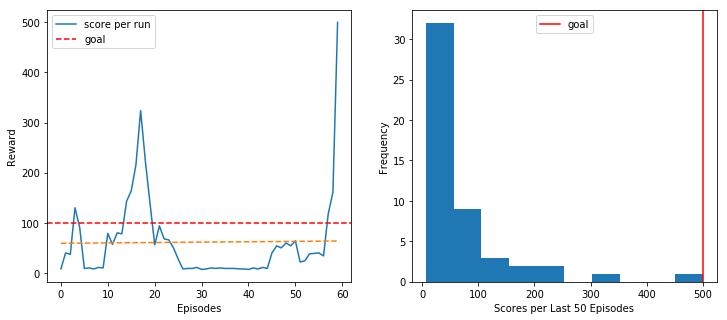

In [9]:
plot_res(scores)

In [10]:
model.save('model2.h5')

In [11]:
model = load_model('model2.h5')

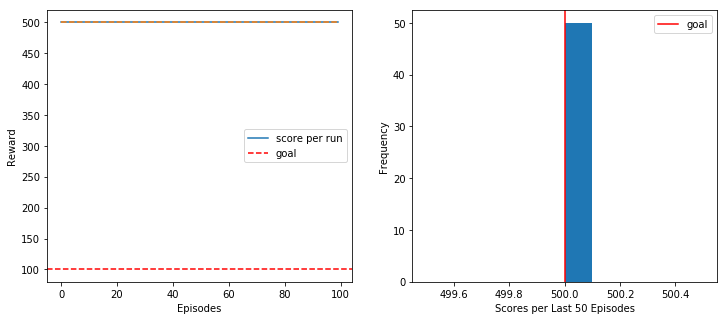

Average score over 100 episodes: 500.0


In [12]:
TEST_EPISODES = 100
goal_steps = 500
epsilon = 0.0
output_size = 2

scores = []
for episode in range(TEST_EPISODES):
    state = env.reset()
    
    score = 0
    for _ in range(goal_steps):
        env.render()
        
        state = state.reshape(-1, len(state))
        action = next_action(state, output_size)
        
        new_state, reward, done, info = env.step(action)
        score += reward
        
        state = new_state
        if(done):
            break
            
    scores.append(score)
        
plot_res(scores)        
print("Average score over {} episodes: {}".format(TEST_EPISODES, sum(scores)/len(scores)))